Change from v1: 
- some cleanup on code. Also: compares epsilon-greedy with random.
- removed covar-hack

In [1]:
import torch
from torch import nn
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats
import pyro

import pandas as pd
import seaborn as sns
sns.set(style="darkgrid")

## Vector-bandit
Assume there are $U$ users and $I$ items. Each are represented by a $d$ dimensional vector. All the vectors are normalized.

Given that you show item i to user u, the probability that u will click is $X^T_u Y_i$.

We implement the environment 

In [2]:
class ClickProbEnv():
    def __init__(self, d = 10, U = 10, I = 10, batch_size = 4, p_profilechange = 0.01):
        self.batch_size = batch_size
        self.U = U
        self.I = I
        self.d = d
        self.p_profilechange = p_profilechange
        X = torch.rand(U,d) - 0.5
        self.X = X/X.norm(2,1,keepdim=True)
        Y = torch.rand(I,d) - 0.5
        self.Y = Y/Y.norm(2,1,keepdim=True)
        
    def click_prob(self, u, i):
        return torch.max(torch.tensor(0.0),((self.X[u,]*self.Y[i,]).sum(dim= 1, keepdim=True)))
    
    def step(self, u, i):
        p = self.click_prob(u,i)
        
        self.sample_new_profiles()
        return (torch.rand((len(u),1)) <= p).float()
    
    def get_users(self, bs = None):
        if bs is None:
            bs = self.batch_size
        return torch.randint(self.U, (bs,)).long()
    
    def sample_new_profiles(self):
        # users
        num_change = int(self.U*self.p_profilechange)
        new_idx = np.random.randint(low = 0, high = self.U, size = num_change)
        newvec = torch.rand(num_change, self.d)-0.5
        newvec = newvec/newvec.norm(2,1,keepdim=True)
        env.X[new_idx,] = newvec

        num_change = int(self.I*self.p_profilechange)
        new_idx = np.random.randint(low = 0, high = self.I, size = num_change)
        newvec = torch.rand(num_change, self.d)-0.5
        newvec = newvec/newvec.norm(2,1,keepdim=True)
        env.Y[new_idx,] = newvec

# Case 1: Contextual
Let us build a high dimensional complex environment:

In [3]:
env = ClickProbEnv(U = 100, I = 100, d = 10, p_profilechange=0.0)
steps = 20000 # number of steps in each game
evals = 5 # During evaluation, how many times should we evaluate the bandit?
results = {}

def calc_statistics(results, final_steps = 500):
    """
    Function that takes in a dict of results and computes different statistics across models.
    INPUT:
    results = {'name' : {
        'rewards' : a eval x steps reward matrix
        }}
    """
    for name, model in results.items():
        cum_reward_per_eval = model['rewards'].cumsum(1).float()/ torch.arange(1, steps+1).float()
        
        results[name]['cumreward_mean'] = cum_reward_per_eval.mean(0)
        results[name]['cumreward_std'] = cum_reward_per_eval.std(0)
        results[name]['finalreward_mean'] = model['rewards'][:,-final_steps:].mean()
        results[name]['finalreward_std'] = model['rewards'][:,-final_steps:].std()

    return results

###  Finding lower bound benchmark: No context, pull best arm
Just as a benchmark. If we knew what arm to pull, what would our average reward be?  
A simple evaluation to find the average reward per action:

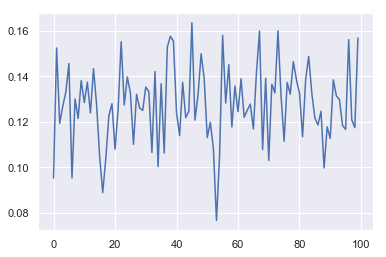

The best policy without user knowledge is to execute arm 45. Average reward is then 0.16363927721977234


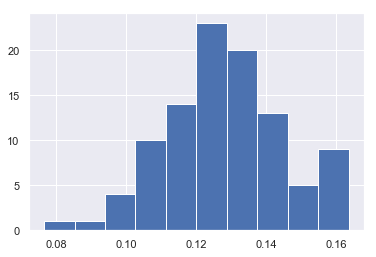

In [4]:
best_actions = [np.mean([env.click_prob(env.get_users(1),item) 
                         for _ in range(1000)]) for item in range(env.I)]
_ = plt.plot(best_actions)
plt.show()
_ = plt.hist(best_actions)
print('The best policy without user knowledge is to execute arm {}. Average reward is then {}'.format( np.argmax(best_actions),max(best_actions)))

### Select optimal actions
We can cheat and use the click_prob(u, i) function in our environment to get the actual real probability of choosing each action. Utilize this to get the optimal policy.

The optimal solution in this environment is to get an average payoff       0.6980000138282776+-0.45899999141693115


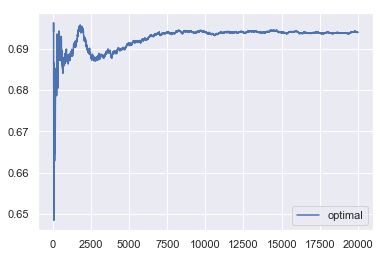

In [5]:
def play_optimal_game():
    user = env.get_users(bs=1)
    action = env.click_prob(user, i = torch.arange(0,env.I)).argmax()
    reward = env.step(user, action.view(-1))
    return reward.squeeze()

reward_evals = torch.zeros((evals,steps))
for t in range(evals):
    r = torch.zeros(steps)
    loss = torch.zeros(steps)

    for i in range(steps):
        r[i] = play_optimal_game()

    reward_evals[t,:] = r

results['optimal'] = {'rewards' : reward_evals}

results = calc_statistics(results)
opt_reward = np.round(results['optimal']['finalreward_mean'],3)
opt_std = np.round(results['optimal']['finalreward_std'],3)
print("The optimal solution in this environment is to get an average payoff \
      {}+-{}".format(opt_reward, opt_std))

dat = pd.DataFrame({name : val
                    for name, model in results.items()
                    for key, val in model.items() 
                    if key == "cumreward_mean"})
sns.lineplot(data=dat[50:])

## Matrix Factorization
we let the bernoulli-agent do an epsilon greedy search with different epsilon parameters

In [6]:
class MatrixFactorization(nn.Module):
    def __init__(self, U, I, dim = 5):
        super(MatrixFactorization, self).__init__()
        self.U = U
        self.I = I
        self.dim = dim
        self.item_emb = nn.Embedding(self.I, self.dim)
        self.user_emb = nn.Embedding(self.U, self.dim)
    def forward(self, users, items):
        uservec = self.user_emb(users)
        itemvec = self.item_emb(items)
        score = (uservec*itemvec).sum(dim=1, keepdim =True)
        return score
    
    def argmax(self, users):
        uservec = self.user_emb(users)
        itemvec = self.item_emb.weight.permute(1,0)
        scores = uservec.matmul(itemvec)
        best_action = scores.argmax(dim=1, keepdim=True)
        return best_action

In [7]:
#####################
### REPLAY MEMORY ###
#####################

from collections import namedtuple
import random
Transition = namedtuple('Transition',
                        ('user', 'action', 'reward'))

class ReplayMemory(object):

    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, *args):
        """Saves a transition."""
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [8]:
def get_batch(bs = 16):
    transitions = memory.sample(bs)
    batch = Transition(*zip(*transitions))
    sample = {
        'user' : torch.cat(batch.user).view(-1,1),
        'action' : torch.cat(batch.action).view(-1,1),
        'reward' : torch.cat(batch.reward).view(-1,1)
        }
    return sample

In [9]:
def play_eps_game(ep = 0.05):
    # Sample user
    user = env.get_users(bs=1)

    # Select action:
    if np.random.rand() > ep:
        action = mf.argmax(user)[0]
    else:
        action = torch.randint(low = 0, high=env.I, size = (1,)).long()

    reward = env.step(user, action.view(-1))

    memory.push(user, action, reward)
    return reward.squeeze()

In [10]:
def train_batch():
    batch = get_batch()
    yhat = mf(users = batch['user'].view(-1), items = batch['action'].view(-1))
    loss = criterion(yhat,batch['reward'])
    optim.zero_grad()
    loss.backward()
    optim.step()
    return loss.data

### Train with different epsilons

In [16]:
tmp_results = {}
for eps in [0.0, 0.05, 0.1]: # ,0.5
    reward_evals = torch.zeros((evals,steps)).float()
    for t in range(evals):
        memory = ReplayMemory(5000)
        mf = MatrixFactorization(env.U, env.I,dim=10)
        criterion = nn.MSELoss()
        optim = torch.optim.Adam(mf.parameters(),lr=0.01)

        r = torch.zeros(steps)
        loss = torch.zeros(steps)

        #warmup:
        for _ in range(20):
            play_eps_game(1.0)

        for i in range(steps):
            r[i] = play_eps_game(eps)
            loss[i] = train_batch()
        reward_evals[t,:] = r
        
        # calc greedy end reward
        r_greedy = torch.zeros(1000)
        for i in range(len(r_greedy)):
            r_greedy[i] = play_eps_game(0.0)

    tmp_results['lowLReps_{}'.format(eps)] = {'rewards' : reward_evals}

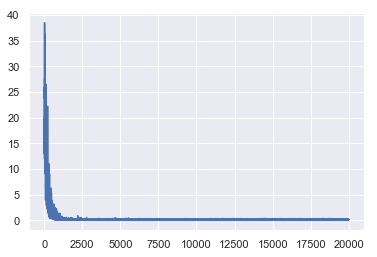

In [17]:
_  = plt.plot(loss.numpy())

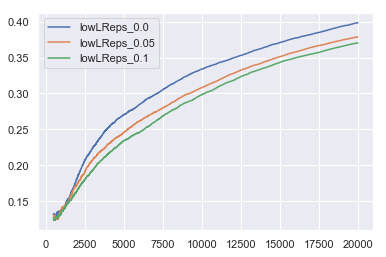

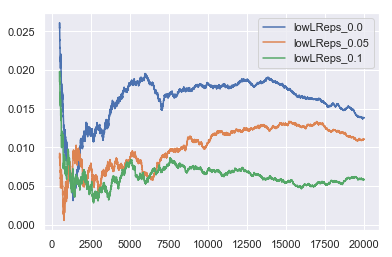

In [18]:
tmp_results = calc_statistics(tmp_results)
dat = pd.DataFrame({name : val
                    for name, model in tmp_results.items()
                    for key, val in model.items() 
                    if key == "cumreward_mean"})
_ = sns.lineplot(data=dat[500:], dashes=False)

plt.show()

dat = pd.DataFrame({name : val
                    for name, model in tmp_results.items()
                    for key, val in model.items() 
                    if key == "cumreward_std"})
_ = sns.lineplot(data=dat[500:], dashes=False)
plt.show()

In [21]:
# Keep the best ones
results['lowLReps_0.05'] = tmp_results['lowLReps_0.05']
results['lowLReps_0.0'] = tmp_results['lowLReps_0.0']

### train random for reference

In [20]:
def play_random_game(ep=None):
    user = env.get_users(bs=1)
    action = torch.randint(low = 0, high=env.I, size = (1,)).long()
    reward = env.step(user, action.view(-1))
    return reward.squeeze()

reward_evals = torch.zeros((evals,steps)).float()
for t in range(evals):
    r = torch.zeros(steps)
    for i in range(steps):
        r[i] = play_random_game()
    reward_evals[t,:] = r
results['random'] = {'rewards' : reward_evals}

### Final stats

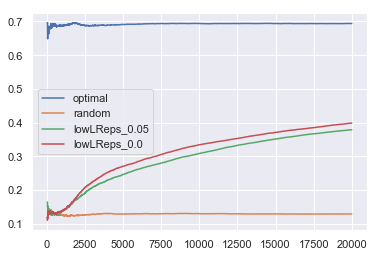

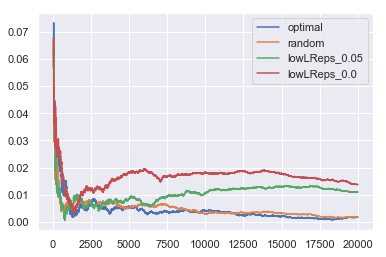

In [22]:
results = calc_statistics(results)
dat = pd.DataFrame({name : val
                    for name, model in results.items()
                    for key, val in model.items() 
                    if key == "cumreward_mean"})
_ = sns.lineplot(data=dat[50:], dashes=False)
plt.show()

dat = pd.DataFrame({name : val
                    for name, model in results.items()
                    for key, val in model.items() 
                    if key == "cumreward_std"})
_ = sns.lineplot(data=dat[50:], dashes=False)

## Final cumulative reward

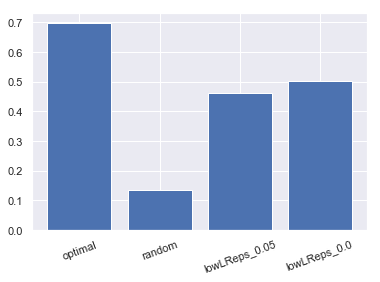

In [23]:
D = {model : dat['finalreward_mean'] for model, dat in results.items()}
_ = plt.bar(range(len(D)), list(D.values()), align='center')
_ = plt.xticks(range(len(D)), list(D.keys()), rotation = 20)